In [8]:
import numpy as np
import matplotlib.pyplot as plt
from vaegan.conditional.models import ConditionalVAECGAN  # if needed for custom objects
from vaegan.gan_SOLUTIONS import ConditionalGAN
from vaegan.vae_SOLUTIONS import ConditionalVAE
from vaegan.conditional.models import ConditionalVAECGAN
import tensorflow as tf
from vaegan.data import MNIST

model = tf.keras.models.load_model("saved_models/cvaecgan_latent32_lr1e-05")
data = MNIST()
# One-hot encode the labels
n_classes = int(data.labels_train.max() + 1)
labels_onehot = tf.one_hot(data.labels_train, 
                           depth=n_classes,
                           dtype=tf.float32).numpy()


digits_to_explore = [3, 5, 8]


N = 5
latent_representations = {}

for digit in digits_to_explore:
    idx = np.where(np.argmax(labels_onehot, axis=1) == digit)[0][:N]
    x_sample = data.images_train[idx]
    y_sample = labels_onehot[idx]


    y_expanded = tf.reshape(y_sample, (-1, 1, 1, 10))
    y_tiled = tf.tile(y_expanded, [1, 32, 32, 1])

    # Concatenate along channel axis
    x_cond = tf.concat([x_sample, y_tiled], axis=-1)  # shape: (batch_size, 32, 32, 11)

    # Now pass into encoder
    z_mean, z_logvar = model.encoder(x_cond, training=False)

   
    z_sample = z_mean  # Or sample from N(z_mean, exp(z_logvar))

    latent_representations[digit] = (z_sample.numpy(), y_sample)

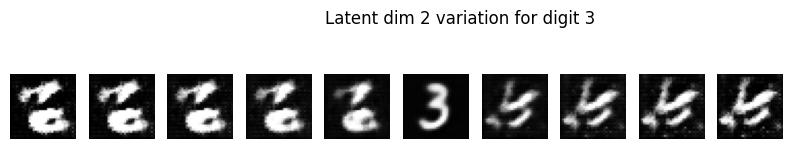

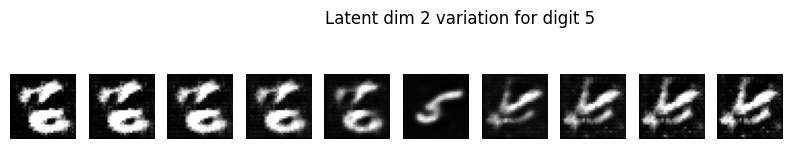

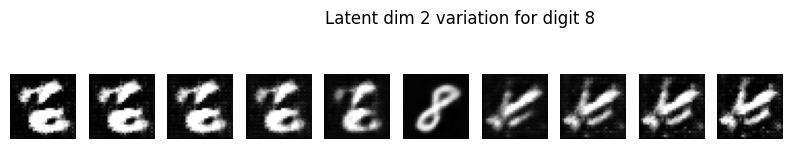

In [9]:
def interpolate_latent(z_center, label, dim=0, span=3, steps=18):
    # Linearly interpolate along one dimension
    interpolations = []
    for alpha in np.linspace(-span, span, steps):
        z = z_center.copy()
        z[:, dim] += alpha
        interpolations.append(model.decoder(tf.concat([z, label], axis=1)))
    return tf.concat(interpolations, axis=0)

# Plot interpolations for one example from each digit
for digit in digits_to_explore:
    z_sample, y_sample = latent_representations[digit]
    z = z_sample[1:2]
    y = y_sample[1:2]

    imgs = interpolate_latent(z, y, dim=4, span=110, steps=11)

    plt.figure(figsize=(12, 2))
    for i in range(10):
        plt.subplot(1, 12, i+1)
        plt.imshow(imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Latent dim 2 variation for digit {digit}')
    plt.show()


/project/nanocourse/SWE_OOP/train11/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/project/nanocourse/SWE_OOP/train11/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


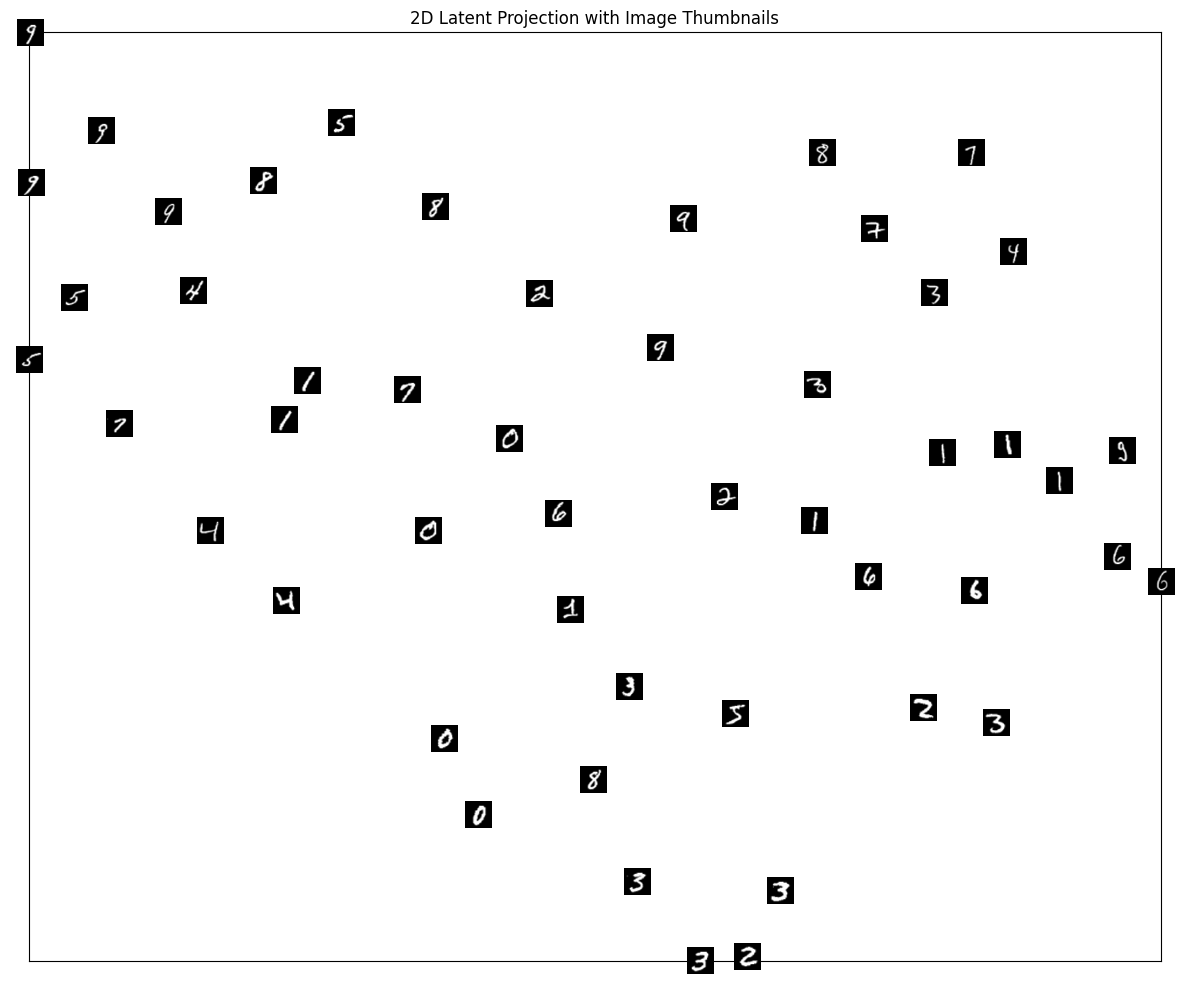

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.manifold import TSNE
import umap

# Choose your dimensionality reduction method
USE_TSNE = False   # Set to False to use UMAP

# Step 1: Select data
num_samples = 50
x_sample = data.images_train[:num_samples]
y_sample = labels_onehot[:num_samples]

# Step 2: Encode to latent space
# Ensure encoder input is conditioned correctly
y_expanded = tf.reshape(y_sample, (-1, 1, 1, y_sample.shape[-1]))
y_tiled = tf.tile(y_expanded, [1, x_sample.shape[1], x_sample.shape[2], 1])
x_cond = tf.concat([x_sample, y_tiled], axis=-1)

z_mean, z_logvar = model.encoder(x_cond, training=False)
z_sample = z_mean  # shape: (num_samples, latent_dim)

# Step 3: Dimensionality reduction to 2D
if USE_TSNE:
    reducer = TSNE(n_components=2, perplexity=30, random_state=1234)
else:
    reducer = umap.UMAP(n_components=2, random_state=1234)

z_2d = reducer.fit_transform(z_sample)

# Step 4: Plot with image thumbnails
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title("2D Latent Projection with Image Thumbnails")

# Normalize coordinates to [0, 1] for plotting
x_min, x_max = np.min(z_2d, axis=0), np.max(z_2d, axis=0)
z_2d_norm = (z_2d - x_min) / (x_max - x_min)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

for i in range(num_samples):
    img = x_sample[i].squeeze()
    im = OffsetImage(img, zoom=0.6, cmap='gray')
    ab = AnnotationBbox(im, z_2d_norm[i], frameon=False)
    ax.add_artist(ab)

ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()
